In [8]:
!pip install transformers
!pip install timm
!pip install deeplake

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
import timm

In [10]:
from dataprocessing import DataLoaderWrapper

data=DataLoaderWrapper(batch_size=32, image_size=224)
#celebA_train,celebA_val,celebA_test=data.initialize_celebA_dataloaders()
adience=data.initialize_adience_dataloaders()

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/adience



-

hub://activeloop/adience loaded successfully.



|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-train



|

hub://activeloop/celeb-a-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-val



/

hub://activeloop/celeb-a-val loaded successfully.



\

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/celeb-a-test



-

hub://activeloop/celeb-a-test loaded successfully.



In [11]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

#model.eval()  # Set the model to evaluation mode
'''
# Prepare to collect the predictions
all_probabilities = []

with torch.no_grad():
    for test_images, age_labels, gender_labels in celebA_val:
        out = model(test_images)

        # Apply softmax to calculate probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Collect the probabilities for further processing or analysis
        all_probabilities.append(probabilities)

#probabilities = torch.nn.functional.softmax(out[0], dim=0)
'''

'\n# Prepare to collect the predictions\nall_probabilities = []\n\nwith torch.no_grad():\n    for test_images, age_labels, gender_labels in celebA_val:\n        out = model(test_images)\n\n        # Apply softmax to calculate probabilities\n        probabilities = torch.nn.functional.softmax(outputs, dim=1)\n\n        # Collect the probabilities for further processing or analysis\n        all_probabilities.append(probabilities)\n\n#probabilities = torch.nn.functional.softmax(out[0], dim=0)\n'

In [12]:
num_classes = 4  # 2 classes: male and female
model.head = nn.Linear(model.head.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [13]:
'''
for batch in adience:
    print(batch)
    break  # Just print the first batch to see what's inside
'''

"\nfor batch in adience:\n    print(batch)\n    break  # Just print the first batch to see what's inside\n"

In [14]:
num_epochs = 5

# Training loop
model.train()
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):

    total_loss = 0
    correct = 0
    total = 0

    for batch in adience:  # Assuming the DataLoader returns a dictionary
        images = batch['images'].to(device)

        # Make sure genders are in the correct shape and type
        genders = batch['genders']
        if len(genders.size()) > 1:  # Assuming genders could be one-hot encoded
            genders = torch.argmax(genders, dim=1)
        genders = genders.to(device).long()  # Ensure the tensor is of type torch.long

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, genders)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == genders).sum().item()
        total += genders.size(0)

    avg_train_loss = total_loss / len(adience)
    train_losses.append(avg_train_loss)
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    '''
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []
    total_val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in adience_val:
            val_images = batch['images'].to(device)

            # Make sure genders are in the correct shape and type for validation
            val_genders = batch['genders']
            if len(val_genders.size()) > 1:  # Assuming genders could be one-hot encoded
                val_genders = torch.argmax(val_genders, dim=1)
            val_genders = val_genders.to(device).long()


            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_genders)
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_genders).sum().item()
            val_total += val_genders.size(0)

    avg_val_loss = total_val_loss / len(adience_val)
    val_accuracy = val_correct / val_total

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    '''

# Save the trained model
torch.save(model.state_dict(), 'adience_vit_model.pth')

Epoch [1/5], Train Loss: 0.0030, Train Accuracy: 0.9988
Epoch [2/5], Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch [3/5], Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch [4/5], Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch [5/5], Train Loss: 0.0000, Train Accuracy: 1.0000


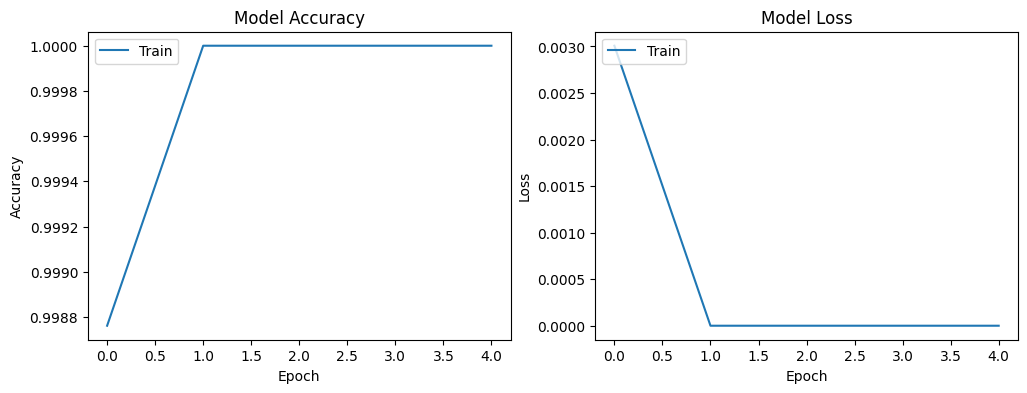

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
#plt.plot(val_accuracies, label='Validation')
plt.title('Model Accuracy - Gender')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
#plt.plot(val_losses, label='Validation')
plt.title('Model Loss - Gender')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

## Age Classification

In [18]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_classes = 8  # 8 different age groups
model.head = nn.Linear(model.head.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [19]:
num_epochs = 5

# Training loop
model.train()
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):

    total_loss = 0
    correct = 0
    total = 0

    for batch in adience:  # Assuming the DataLoader returns a dictionary
        images = batch['images'].to(device)

        # Make sure genders are in the correct shape and type
        ages = batch['ages']
        if len(ages.size()) > 1:  # Assuming ages could be one-hot encoded
            ages = torch.argmax(ages, dim=1)
        ages = ages.to(device).long()  # Ensure the tensor is of type torch.long

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, ages)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == ages).sum().item()
        total += ages.size(0)

    avg_train_loss = total_loss / len(adience)
    train_losses.append(avg_train_loss)
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    print('Age Classification\n')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    '''
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    val_accuracies = []
    total_val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in adience_val:
            val_images = batch['images'].to(device)

            # Make sure genders are in the correct shape and type for validation
            val_genders = batch['genders']
            if len(val_genders.size()) > 1:  # Assuming genders could be one-hot encoded
                val_genders = torch.argmax(val_genders, dim=1)
            val_genders = val_genders.to(device).long()


            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_genders)
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_genders).sum().item()
            val_total += val_genders.size(0)

    avg_val_loss = total_val_loss / len(adience_val)
    val_accuracy = val_correct / val_total

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    '''

# Save the trained model
torch.save(model.state_dict(), 'adience_vit_model.pth')

/usr/local/lib/python3.10/dist-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


Age Classification

Epoch [1/5], Train Loss: 0.0073, Train Accuracy: 0.9983
Age Classification

Epoch [2/5], Train Loss: 0.0000, Train Accuracy: 1.0000
Age Classification

Epoch [3/5], Train Loss: 0.0000, Train Accuracy: 1.0000
Age Classification

Epoch [4/5], Train Loss: 0.0000, Train Accuracy: 1.0000
Age Classification

Epoch [5/5], Train Loss: 0.0000, Train Accuracy: 1.0000


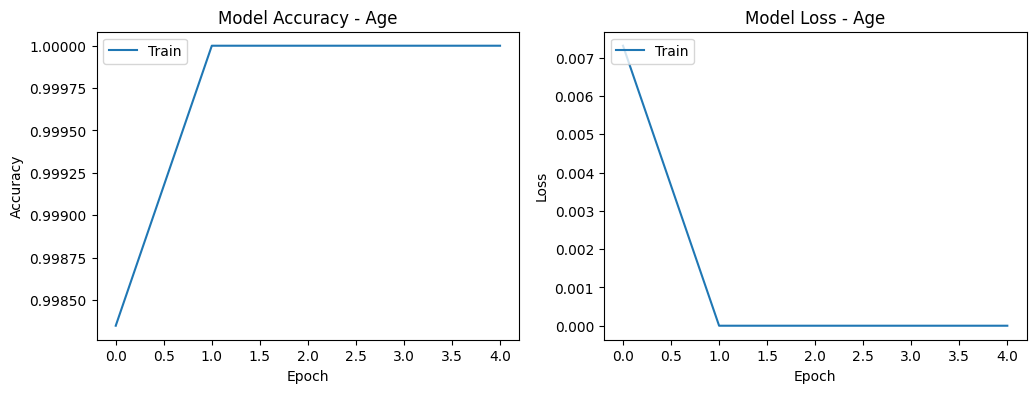

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
#plt.plot(val_accuracies, label='Validation')
plt.title('Model Accuracy - Age')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
#plt.plot(val_losses, label='Validation')
plt.title('Model Loss - Age')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()